In [ ]:
from google.colab import files
uploaded = files.upload()


Saving kvasir-seg.zip to kvasir-seg.zip


In [ ]:
import zipfile
import os


zip_file_path = "kvasir-seg.zip"
extract_folder = "Kvasir-SEG"


if os.path.exists(zip_file_path):
    with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
        zip_ref.extractall(extract_folder)


    print(os.listdir(extract_folder))
else:
    print(f"file {zip_file_path} not exist")


['Kvasir-SEG']


In [ ]:
import os

base_dir = "Kvasir-SEG/Kvasir-SEG"
images_dir = os.path.join(base_dir, "images")
masks_dir = os.path.join(base_dir, "masks")


if os.path.exists(images_dir) and os.path.exists(masks_dir):
    image_files = os.listdir(images_dir)
    mask_files = os.listdir(masks_dir)

    print(f"Number of images: {len(image_files)}")
    print(f"Number of masks: {len(mask_files)}")
else:
    print(f"Either {images_dir} or {masks_dir} does not exist!")

Number of images: 1000
Number of masks: 1000


In [ ]:
import torch
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


base_dir = "Kvasir-SEG/Kvasir-SEG"
images_dir = os.path.join(base_dir, "images")
masks_dir = os.path.join(base_dir, "masks")


IMG_SIZE = (224, 224)
BATCH_SIZE = 16


image_paths = sorted([os.path.join(images_dir, fname) for fname in os.listdir(images_dir)])
mask_paths = sorted([os.path.join(masks_dir, fname) for fname in os.listdir(masks_dir)])


assert len(image_paths) == len(mask_paths), "image not equal to musk"


train_images, val_images, train_masks, val_masks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)


class KvasirDataset(Dataset):
    def __init__(self, images, masks, transform=None, target_transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = cv2.imread(self.images[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[idx], cv2.IMREAD_GRAYSCALE)


        image = cv2.resize(image, IMG_SIZE)
        mask = cv2.resize(mask, IMG_SIZE)


        image = image / 255.0
        mask = mask / 255.0
        mask = (mask > 0.5).astype(np.float32)


        if self.transform:
            image = self.transform(image).to(torch.float32)
        if self.target_transform:
            mask = self.target_transform(mask).to(torch.float32)

        return image, mask


image_transform = transforms.Compose([
    transforms.ToTensor(),
])

mask_transform = transforms.Compose([
    transforms.ToTensor(),
])


train_dataset = KvasirDataset(train_images, train_masks, transform=image_transform, target_transform=mask_transform)
val_dataset = KvasirDataset(val_images, val_masks, transform=image_transform, target_transform=mask_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


for images, masks in train_loader:
    print("Image batch shape:", images.shape)
    print("Mask batch shape:", masks.shape)
    break


Image batch shape: torch.Size([16, 3, 224, 224])
Mask batch shape: torch.Size([16, 1, 224, 224])


In [ ]:
from transformers import ConvNextModel, ConvNextConfig


convnext_config = ConvNextConfig.from_pretrained("facebook/convnext-tiny-224")
backbone = ConvNextModel.from_pretrained("facebook/convnext-tiny-224", config=convnext_config)

print("ConvNeXt backbone loaded successfully!")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/114M [00:00<?, ?B/s]

ConvNeXt backbone loaded successfully!


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class ConvNeXtSegmentationModel(nn.Module):
    def __init__(self, backbone, num_classes=2):
        super(ConvNeXtSegmentationModel, self).__init__()
        self.backbone = backbone
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(768, 256, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, num_classes, kernel_size=1)
        )

    def forward(self, x):

        features = self.backbone(x).last_hidden_state


        seg_map = self.upsample(features)
        seg_map = nn.functional.interpolate(
            seg_map, size=(224, 224), mode="bilinear", align_corners=False
        )
        return seg_map


Using device: cuda


In [ ]:
import torch
import torch.nn as nn

def fine_tune_model(model, train_loader, val_loader, num_epochs=10, learning_rate=5e-4, device=None):

    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    model.to(device)


    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)


    train_losses = []
    val_ious = []

    for epoch in range(num_epochs):

        model.train()
        total_loss = 0.0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.squeeze(1).long().to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_train_loss:.4f}")


        model.eval()
        total_iou = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.squeeze(1).long().to(device)
                outputs = model(images)
                predictions = torch.argmax(outputs, dim=1)
                iou = calculate_iou(predictions, masks)
                total_iou += iou

        avg_val_iou = total_iou / len(val_loader)
        val_ious.append(avg_val_iou)
        print(f"Validation IoU: {avg_val_iou:.4f}")

    return model, train_losses, val_ious


def calculate_iou(pred_mask, true_mask):
    """
    计算 IoU（交并比）。
    """
    pred_mask = pred_mask.cpu().numpy()
    true_mask = true_mask.cpu().numpy()
    intersection = (pred_mask & true_mask).sum()
    union = (pred_mask | true_mask).sum()
    return intersection / union if union > 0 else 0.0



In [ ]:
def visualize_training_results(train_losses, val_ious):

    if isinstance(train_losses[0], torch.Tensor):
        train_losses = [loss.cpu().item() for loss in train_losses]
    if isinstance(val_ious[0], torch.Tensor):
        val_ious = [iou.cpu().item() for iou in val_ious]

    epochs = range(1, len(train_losses) + 1)


    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, marker='o', label='Training Loss')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_ious, marker='o', color='green', label='Validation IoU')
    plt.title('Validation IoU Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()


    plt.tight_layout()
    plt.show()


In [ ]:
def calculate_metrics(predictions, targets):

    intersection = (predictions & targets).sum().float()
    union = (predictions | targets).sum().float()
    true_positive = intersection
    false_positive = (predictions & ~targets).sum().float()
    false_negative = (~predictions & targets).sum().float()

    # IoU
    iou = (intersection / union) if union > 0 else 0.0
    # Precision
    precision = (true_positive / (true_positive + false_positive)) if (true_positive + false_positive) > 0 else 0.0
    # Recall
    recall = (true_positive / (true_positive + false_negative)) if (true_positive + false_negative) > 0 else 0.0
    # F1-Score
    f1_score = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0

    return iou, precision, recall, f1_score


def inference_and_evaluate(model, val_loader, device=None):

    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    model.to(device)
    model.eval()

    total_iou = 0.0
    total_precision = 0.0
    total_recall = 0.0
    total_f1_score = 0.0

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.squeeze(1).long().to(device)
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1).bool()
            masks = masks.bool()


            iou, precision, recall, f1_score = calculate_metrics(predictions, masks)
            total_iou += iou
            total_precision += precision
            total_recall += recall
            total_f1_score += f1_score


    num_batches = len(val_loader)
    avg_iou = total_iou / num_batches
    avg_precision = total_precision / num_batches
    avg_recall = total_recall / num_batches
    avg_f1_score = total_f1_score / num_batches


    print(f"Final IoU: {avg_iou:.4f}")
    print(f"Final Precision: {avg_precision:.4f}")
    print(f"Final Recall: {avg_recall:.4f}")
    print(f"Final F1-Score: {avg_f1_score:.4f}")

    return avg_iou, avg_precision, avg_recall, avg_f1_score




Epoch 1/40, Loss: 0.2767
Validation IoU: 0.5260
Epoch 2/40, Loss: 0.1636
Validation IoU: 0.6778
Epoch 3/40, Loss: 0.0867
Validation IoU: 0.7479
Epoch 4/40, Loss: 0.0553
Validation IoU: 0.7706
Epoch 5/40, Loss: 0.0388
Validation IoU: 0.7735
Epoch 6/40, Loss: 0.0331
Validation IoU: 0.8002
Epoch 7/40, Loss: 0.0245
Validation IoU: 0.7911
Epoch 8/40, Loss: 0.0202
Validation IoU: 0.7988
Epoch 9/40, Loss: 0.0178
Validation IoU: 0.8025
Epoch 10/40, Loss: 0.0160
Validation IoU: 0.7956
Epoch 11/40, Loss: 0.0145
Validation IoU: 0.8004
Epoch 12/40, Loss: 0.0139
Validation IoU: 0.7961
Epoch 13/40, Loss: 0.0132
Validation IoU: 0.8004
Epoch 14/40, Loss: 0.0117
Validation IoU: 0.8002
Epoch 15/40, Loss: 0.0107
Validation IoU: 0.8015
Epoch 16/40, Loss: 0.0101
Validation IoU: 0.8009
Epoch 17/40, Loss: 0.0101
Validation IoU: 0.8007
Epoch 18/40, Loss: 0.0095
Validation IoU: 0.8026
Epoch 19/40, Loss: 0.0088
Validation IoU: 0.8033
Epoch 20/40, Loss: 0.0086
Validation IoU: 0.8011
Epoch 21/40, Loss: 0.0088
Val

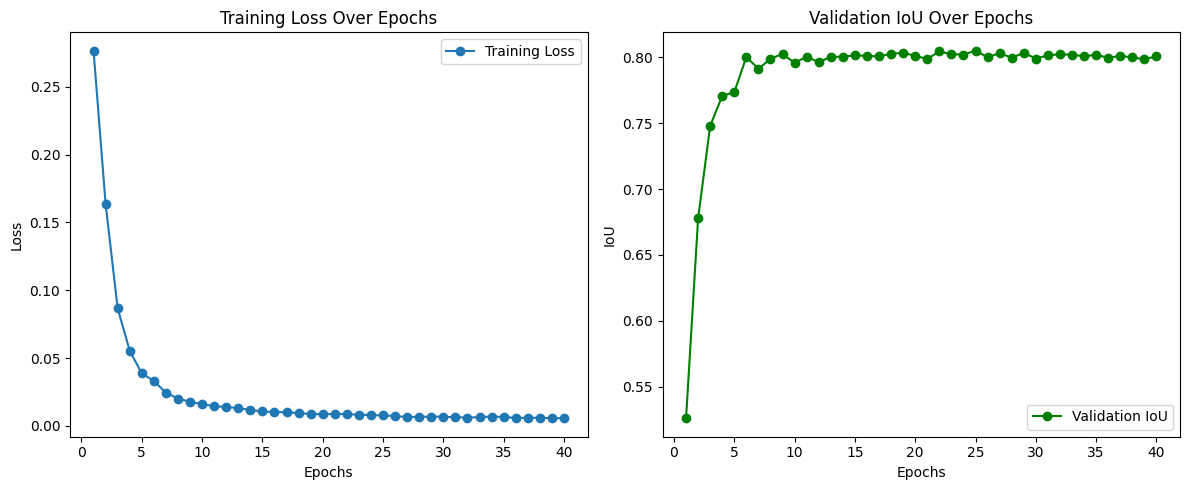

Final IoU: 0.8006
Final Precision: 0.9067
Final Recall: 0.8729
Final F1-Score: 0.8882


(tensor(0.8006, device='cuda:0'),
 tensor(0.9067, device='cuda:0'),
 tensor(0.8729, device='cuda:0'),
 tensor(0.8882, device='cuda:0'))

In [ ]:
model = ConvNeXtSegmentationModel(backbone)

fine_tuned_model, train_losses, val_ious = fine_tune_model(
    model, train_loader, val_loader, num_epochs=40, learning_rate=5e-4
)

visualize_training_results(train_losses, val_ious)
inference_and_evaluate(fine_tuned_model, val_loader)